## 0.Préambule

### Mot introductif

Ce projet de Machine Learning se concentre sur la création d'un système de recommandation de films, s'inspirant d'un article mettant en avant l'efficacité du Cosine Similarity dans les recommandations. Guidé par la passion pour le cinéma et motivé par les avancées de cette mesure de similarité, notre objectif est de développer un système précis et personnalisé pour recommander des films en se basant sur les préférences individuelles des utilisateurs. On s'est basé sur l'ariticle [suivant.](https://naomy-gomes.medium.com/the-cosine-similarity-and-its-use-in-recommendation-systems-cb2ebd811ce1)

 Après avoir récupéré les données via l'API TMDB, des analyses statistiques descriptives ont été effectuées pour comprendre la nature des données. En parallèle, un modèle de recommandation de films a été créé. Pour rendre l'expérience plus interactive, une application visuelle a été développée en utilisant la bibliothèque DASH, offrant une interface conviviale pour explorer les recommandations de films et interagir avec le système de recommandation.

### Importation des modules et packages

#### Pour les requêtes API et exporter les données

In [155]:
import requests
import json
import pandas as pd
import pickle

#### Visualisation et analyse des données

In [156]:
# Lecture et traitement du dataframe
import pandas as pd 
import numpy as np 
import pickle

# Visualisation et analyse graphique des données
import matplotlib.pyplot as plt

# Visualisation et analyse cartographique des données
import geopandas as gpd
import contextily as ctx

# Corrélation entre les données
import seaborn as sns 


#### Modélisation

In [157]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### I. Récupération des données

#### a. Code 

Nous avons utilisé l'API TMDB pour récupérer 10k films même si après nettoyage de la base de donnée nous en aurons moins.

On commence par récupérer les *id* des films "popular", puis on effectue des requêtes pour avoir les détails de tous ses films. 

À la fin des requêtes, on exporte le fichier en JSON. Le fichier fait 1/2Go, ce qui s'explique notamment par la quantité de texte importante dans le dataframe.

In [ ]:
# Votre clé d'API TMDb
api_key = '28c6630049f5d468217e4f34963c03a6'

# URL de base de l'API TMDb pour les films populaires
base_url_popular = 'https://api.themoviedb.org/3/movie/popular'

# Nombre total de films à récupérer
total_movies = 10000

# Nombre de films à récupérer par requête
movies_per_request = 20

# Champs de base pour les films
fields = 'id'  # Ajoutez les champs que vous souhaitez récupérer ici

# Liste pour stocker tous les films avec leurs détails
all_movies_details = []

# Nombre de requêtes nécessaires pour obtenir le nombre total de films
num_requests = total_movies // movies_per_request

# Effectuer les requêtes pour récupérer les films
for page in range(1, num_requests + 1):
    params = {
        'api_key': api_key,
        'page': page,
        'fields': fields
    }
    response = requests.get(base_url_popular, params=params)#, timeout=10)  # Définir un délai d'attente de 10 secondes

    if response.status_code == 200:
        movies_data = response.json()
        movies_reco = movies_data.get('results', [])

            # Pour chaque film, récupérer les détails supplémentaires
        for movie in movies_reco:
            movie_id = movie['id']
            movie_details_url = f'https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&append_to_response=credits,keywords'
            movie_details_response = requests.get(movie_details_url)
            if movie_details_response.status_code == 200:
                movie_details = movie_details_response.json()
                all_movies_details.append(movie_details)
                print(f"Film {movie['title']} récupéré avec détails supplémentaires.")
            else:
                print(f"Erreur lors de la récupération des détails pour {movie['title']}. Statut : {movie_details_response.status_code}")
        print(f"Page {page} récupérée. Total de films récupérés : {len(all_movies_details)}")

    else:
        print(f"Erreur lors de la requête pour la page {page}. Statut : {response.status_code}")


    if len(all_movies_details) >= total_movies:
        break

# Enregistrer les données complètes dans un fichier JSON
with open('movies_data_complete.json', 'w', encoding='utf-8') as f:
    json.dump(all_movies_details, f, ensure_ascii=False, indent=4)

print("Récupération des films avec détails complets terminée. Les données ont été enregistrées dans movies_data_complete.json.")

#### b. Affichage du DataFrame

On utilise le fichier Json qu'on a exporté pour éviter de faire la requête API à nouveau.

In [158]:
movies_data=pd.read_json('movies_data_complete.json')
movies_data.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits,keywords
0,False,/1X7vow16X7CnCoexXh4H4F2yDJv.jpg,None,200000000,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",https://www.killersoftheflowermoonmovie.com,466420,tt5537002,en,Killers of the Flower Moon,...,206,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Greed is an animal that hungers for blood.,Killers of the Flower Moon,False,7.622,1479,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi..."
1,False,/zIYROrkHJPYB3VTiW1L9QVgaQO.jpg,None,40000000,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://freelance.movie,897087,tt15744298,en,Freelance,...,108,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Retirement didn't suit him.,Freelance,False,6.539,322,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta..."
2,False,/r1eCvALF6fN7anVYL8Zn7PaceD1.jpg,None,125000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",https://www.wonkamovie.com,787699,tt6166392,en,Wonka,...,117,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Every good thing in this world started with a ...,Wonka,False,7.271,316,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}..."
3,False,/k1KrbaCMACQiq7EA0Yhw3bdzMv7.jpg,"{'id': 489724, 'name': 'The Trolls Collection'...",95000000,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",https://www.delfi.lt,901362,tt14362112,en,Trolls Band Together,...,92,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There are some new trolls on the block.,Trolls Band Together,False,7.172,379,"{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}..."
4,False,/9PqD3wSIjntyJDBzMNuxuKHwpUD.jpg,None,0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",https://www.netflix.com/title/81218917,1075794,tt5755238,en,Leo,...,102,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Breaking out this November.,Leo,False,7.609,597,"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'..."


Quelques informations sur la base de données :

In [5]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  10000 non-null  bool   
 1   backdrop_path          9922 non-null   object 
 2   belongs_to_collection  2578 non-null   object 
 3   budget                 10000 non-null  int64  
 4   genres                 10000 non-null  object 
 5   homepage               10000 non-null  object 
 6   id                     10000 non-null  int64  
 7   imdb_id                9958 non-null   object 
 8   original_language      10000 non-null  object 
 9   original_title         10000 non-null  object 
 10  overview               10000 non-null  object 
 11  popularity             10000 non-null  float64
 12  poster_path            9996 non-null   object 
 13  production_companies   10000 non-null  object 
 14  production_countries   10000 non-null  object 
 15  rel

### II. Nettoyage des données

#### II.1. Choix des variables utiles

Tout d'abord, on récupère les données qui nous seront utiles dans la création de l'application et on supprime les films doublons.

On ne garde que les films qui sont sortis et dont le revenu et le runtime sont strictement positifs. 

In [159]:
selected_columns=['id','title','original_title','overview','release_date','adult','popularity','vote_average','vote_count','poster_path','runtime','genres','production_companies','production_countries','spoken_languages','credits','keywords','status']
movies_data=movies_data[selected_columns]
movies_data= movies_data.drop_duplicates(subset='title', keep='first')
movies_data=movies_data[movies_data.status=='Released']
movies_data= movies_data[movies_data.runtime!=0]
movies_data.head()

,id,title,original_title,overview,release_date,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,credits,keywords,status
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,2023-10-18,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...","[{'id': 194232, 'logo_path': '/oE7H93u8sy5vvW5...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi...",Released
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,2023-01-05,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...","[{'id': 89171, 'logo_path': '/c3ttVfx0itQzk2vO...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta...",Released
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,2023-12-06,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...","[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}...",Released
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",2023-10-12,False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}...",Released
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,2023-11-17,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 878, 'logo_path': '/e2AZdsQdkhN0qJhoN4...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'...",Released


Enfin, on ne conserve que l'année de sortie du film.

In [160]:
movies_data.release_date=pd.to_datetime(movies_data.release_date, format='%Y-%m-%d', errors = 'ignore')
movies_data['release_year']=movies_data['release_date'].dt.year 
movies_data.drop(['release_date','status'],axis=1,inplace=True)
movies_data=movies_data.reset_index(drop=True)
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,credits,keywords,release_year
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...","[{'id': 194232, 'logo_path': '/oE7H93u8sy5vvW5...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi...",2023
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...","[{'id': 89171, 'logo_path': '/c3ttVfx0itQzk2vO...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta...",2023
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...","[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}...",2023
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}...",2023
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 878, 'logo_path': '/e2AZdsQdkhN0qJhoN4...","[{'iso_3166_1': 'AU', 'name': 'Australia'}, {'...","[{'english_name': 'English', 'iso_639_1': 'en'...","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'...",2023


####  II.2. Résolution des problèmes du dataset

On travaille à présent sur les différentes colonnes où les données ne sont pas directement exploitables comme *genres*, *productions_companies* etc. On ne conserve que les informations importantes : dans chaque dictionnaire, on conserve les valeurs de *name*. 

In [161]:
movies_data.loc[0].genres

[{'id': 80, 'name': 'Crime'},
 {'id': 18, 'name': 'Drama'},
 {'id': 36, 'name': 'History'}]

On crée une fonction pour directement extraire les données importanes de *genres, production_countries, spoken_languages & production_companies*

In [162]:
def convert(text):
    L = []
    for i in text:
        L.append(i["name"]) 
    return L 
movies_data['genres'] = movies_data['genres'].apply(convert)
movies_data['production_countries'] = movies_data['production_countries'].apply(convert).apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
movies_data['spoken_languages']=movies_data['spoken_languages'].apply(convert)
movies_data['production_companies']=(movies_data['production_companies'].apply(convert)).apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
#On garde que la principale entreprise de production.
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,credits,keywords,release_year
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,United States of America,"[English, Français, Latin]","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1157, 'name': 'husband wi...",2023
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,United States of America,"[English, Español]","{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 6285, 'name': 'coup d'eta...",2023
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,United Kingdom,[English],"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 715, 'name': 'chocolate'}...",2023
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,United States of America,"[English, Lietuvių]","{'cast': [{'adult': False, 'gender': 1, 'id': ...","{'keywords': [{'id': 3490, 'name': 'pop star'}...",2023
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,Australia,[English],"{'cast': [{'adult': False, 'gender': 2, 'id': ...","{'keywords': [{'id': 1517, 'name': 'classroom'...",2023


On gère la colonnes *keywords* de la même manière sauf qu'il existe des films sans mots clés. On supprime ces films car cette colonne est très importante pour le modèle que l'on va créer.

In [163]:
movies_data['keywords'] = movies_data['keywords'].apply(lambda x: x['keywords'] if isinstance(x, dict) and 'keywords' in x else None) # regarder Robot Apocalypse Keywords
movies_data = movies_data[movies_data['keywords'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
movies_data["keywords"]=movies_data["keywords"].apply(convert)
movies_data.reset_index(drop=True,inplace=True)
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,credits,keywords,release_year
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,United States of America,"[English, Français, Latin]","{'cast': [{'adult': False, 'gender': 2, 'id': ...","[husband wife relationship, based on novel or ...",2023
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,United States of America,"[English, Español]","{'cast': [{'adult': False, 'gender': 2, 'id': ...","[coup d'etat, dictatorship, political assassin...",2023
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,United Kingdom,[English],"{'cast': [{'adult': False, 'gender': 2, 'id': ...","[chocolate, musical, prequel]",2023
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,United States of America,"[English, Lietuvių]","{'cast': [{'adult': False, 'gender': 1, 'id': ...","[pop star, brother, musical, sequel, based on ...",2023
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,Australia,[English],"{'cast': [{'adult': False, 'gender': 2, 'id': ...","[classroom, musical, bucket list]",2023


Enfin, on sépare les *credits* entre le *cast* et le *crew*, où respectivement on récupère les trois acteurs principaux et le réalisateur.

In [164]:
movies_data['cast'] = movies_data['credits'].apply(lambda x: x.get('cast') if isinstance(x, dict) else None)
movies_data['crew'] = movies_data['credits'].apply(lambda x: x.get('crew') if isinstance(x, dict) else None)
movies_data.drop("credits", axis=1, inplace=True)
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,keywords,release_year,cast,crew
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,United States of America,"[English, Français, Latin]","[husband wife relationship, based on novel or ...",2023,"[{'adult': False, 'gender': 2, 'id': 6193, 'kn...","[{'adult': False, 'gender': 2, 'id': 27, 'know..."
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,United States of America,"[English, Español]","[coup d'etat, dictatorship, political assassin...",2023,"[{'adult': False, 'gender': 2, 'id': 56446, 'k...","[{'adult': True, 'gender': 2, 'id': 997, 'know..."
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,United Kingdom,[English],"[chocolate, musical, prequel]",2023,"[{'adult': False, 'gender': 2, 'id': 1190668, ...","[{'adult': False, 'gender': 2, 'id': 1299, 'kn..."
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,United States of America,"[English, Lietuvių]","[pop star, brother, musical, sequel, based on ...",2023,"[{'adult': False, 'gender': 1, 'id': 84223, 'k...","[{'adult': False, 'gender': 2, 'id': 10572, 'k..."
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,Australia,[English],"[classroom, musical, bucket list]",2023,"[{'adult': False, 'gender': 2, 'id': 19292, 'k...","[{'adult': False, 'gender': 0, 'id': 7963, 'kn..."


Création de la fonction récupérant les trois acteurs principaux et de la fonction récupérant le réalisateur.

In [165]:
def convert3(text):
    L = []
    counter = 0
    for i in text:
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L 

def fetch_director(text):
    L = []
    for i in text:
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L 
movies_data["cast"]=movies_data["cast"].apply(convert3)
movies_data["crew"]=movies_data["crew"].apply(fetch_director)
movies_data.head()

,id,title,original_title,overview,adult,popularity,vote_average,vote_count,poster_path,runtime,genres,production_companies,production_countries,spoken_languages,keywords,release_year,cast,crew
0,466420,Killers of the Flower Moon,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,False,1145.813,7.622,1479,/dB6Krk806zeqd0YNp2ngQ9zXteH.jpg,206,"[Crime, Drama, History]",Apple Studios,United States of America,"[English, Français, Latin]","[husband wife relationship, based on novel or ...",2023,"[Leonardo DiCaprio, Lily Gladstone, Robert De ...",[Martin Scorsese]
1,897087,Freelance,Freelance,An ex-special forces operative takes a job to ...,False,1243.624,6.539,322,/7Bd4EUOqQDKZXA6Od5gkfzRNb0.jpg,108,"[Action, Comedy]",Endurance Media,United States of America,"[English, Español]","[coup d'etat, dictatorship, political assassin...",2023,"[John Cena, Alison Brie, Juan Pablo Raba]",[Pierre Morel]
2,787699,Wonka,Wonka,Willy Wonka – chock-full of ideas and determin...,False,1059.479,7.271,316,/qhb1qOilapbapxWQn9jtRCMwXJF.jpg,117,"[Comedy, Family, Fantasy]",Warner Bros. Pictures,United Kingdom,[English],"[chocolate, musical, prequel]",2023,"[Timothée Chalamet, Calah Lane, Keegan-Michael...",[Paul King]
3,901362,Trolls Band Together,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...",False,920.108,7.172,379,/bkpPTZUdq31UGDovmszsg2CchiI.jpg,92,"[Animation, Family, Music, Fantasy, Comedy]",DreamWorks Animation,United States of America,"[English, Lietuvių]","[pop star, brother, musical, sequel, based on ...",2023,"[Anna Kendrick, Justin Timberlake, Camila Cabe...",[Walt Dohrn]
4,1075794,Leo,Leo,Jaded 74-year-old lizard Leo has been stuck in...,False,780.064,7.609,597,/pD6sL4vntUOXHmuvJPPZAgvyfd9.jpg,102,"[Animation, Comedy, Family]",Happy Madison Productions,Australia,[English],"[classroom, musical, bucket list]",2023,"[Adam Sandler, Bill Burr, Cecily Strong]",[Robert Smigel]


**Conclusion :** Après nettoyage, on a donc 8292 films.

### III. Visualisation des données

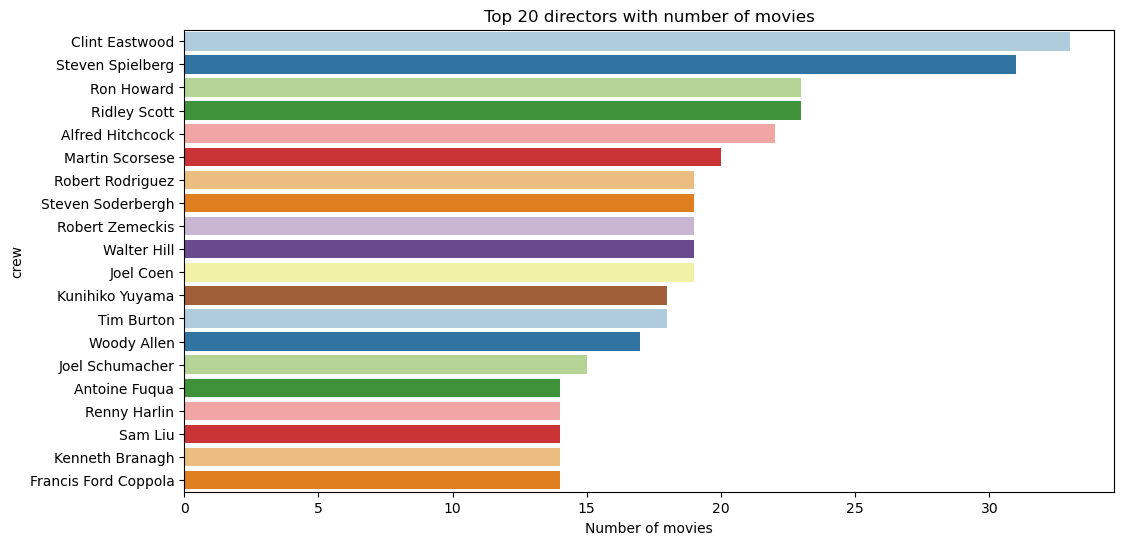

In [124]:
# Conversion de la colonne 'crew' en une série pandas pour faciliter le traitement
directors = movies_data['crew'].explode()

# Création d'un countplot pour les 20 réalisateurs les plus fréquents
plt.figure(figsize=(12, 6))
sns.countplot(y=directors, palette='Paired',
              order=directors.value_counts().index[:20])
plt.title("Top 20 directors with number of movies")
plt.xlabel("Number of movies")
plt.show()

les 10 premiers réalisateurs ont produits plus de 20 films chacun!


Text(0.5, 1.0, 'Top 20 production companies with number of movies released')

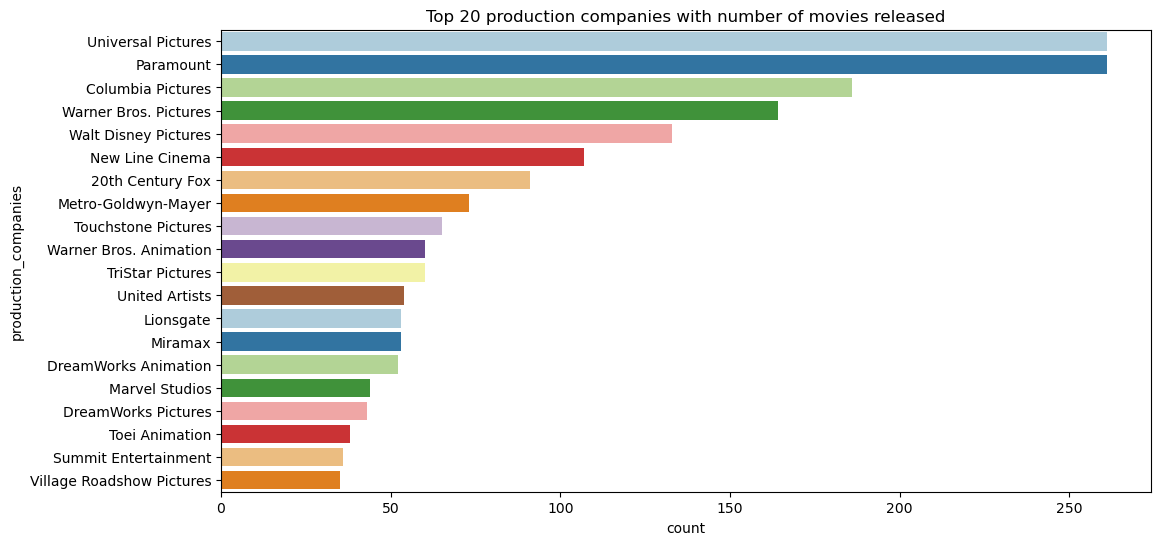

In [125]:
plt.figure(figsize=(12,6))
sns.countplot(y="production_companies",palette = 'Paired', data=movies_data,order=movies_data['production_companies'].value_counts().index[0:20])
plt.title("Top 20 production companies with number of movies released")

les deux companies Universal Pictures et Paramount ont la grande part du marché de production des films avec plus de 250 films produits par chacune!

la plupart des companies ont un volume de production moyen qui dépasse pas 100 films en général

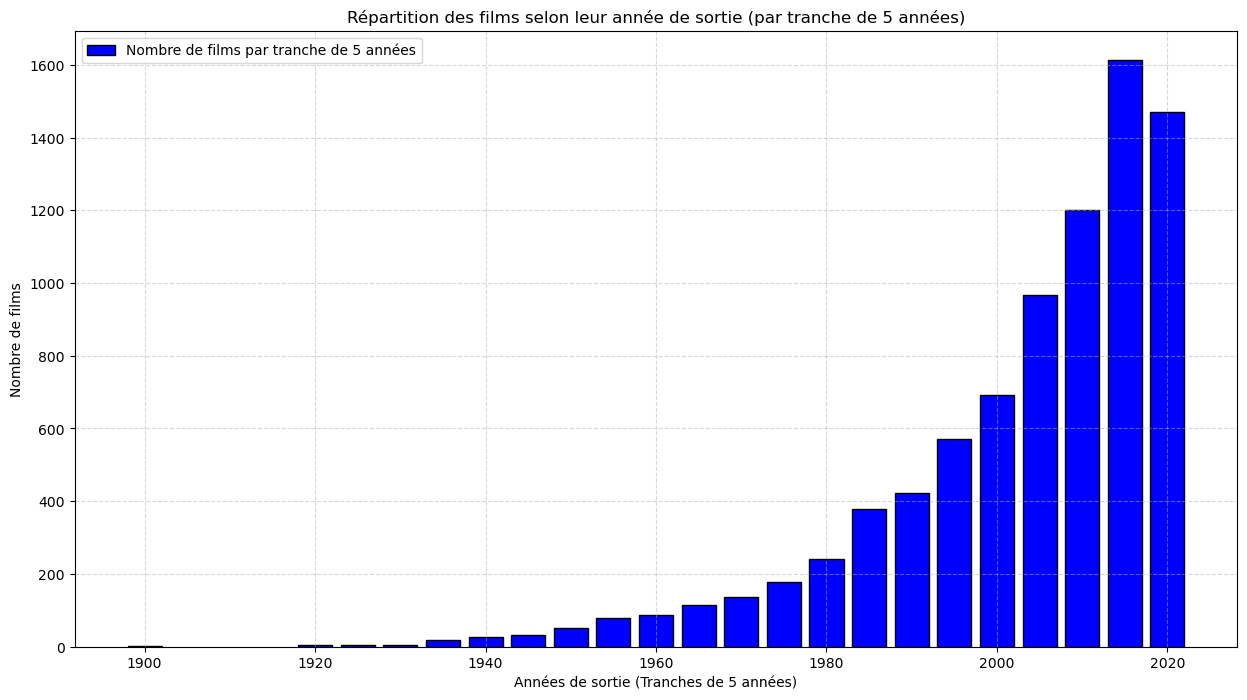

In [25]:
import matplotlib.pyplot as plt

releases = {}
for year in movies_data['release_year']:
    if str(year) not in releases:
        releases[str(year)] = 0
    releases[str(year)] +=1

releases = {k:v for k, v in sorted(releases.items())}

# Création d'un nouveau dictionnaire pour regrouper les années par tranche de 5 ans
grouped_releases = {}

# Regroupement des années par tranche de 5 ans et calcul du nombre de films publiés dans chaque tranche
for year, count in releases.items():
    interval = (int(year) // 5) * 5  # Calcul de l'intervalle de 5 ans
    if interval not in grouped_releases:
        grouped_releases[interval] = 0
    grouped_releases[interval] += count

fig = plt.figure(figsize=(15, 8))
plt.bar(grouped_releases.keys(), grouped_releases.values(), width=4, align='center', 
        label="Nombre de films par tranche de 5 années", color='blue', edgecolor='black')
plt.xlabel("Années de sortie (Tranches de 5 années)")
plt.ylabel("Nombre de films")
plt.title("Répartition des films selon leur année de sortie (par tranche de 5 années)")
plt.legend()
plt.grid(linestyle='dashed', alpha=0.5)
plt.show()


entre les annnées 2013 et 2018 la production des films était à son maximum,avec plus de 1600 films produits pendant cette période.

la production des films est croissante dans le temps sauf pendant la période du covid où la production cinématographique a été affecté.



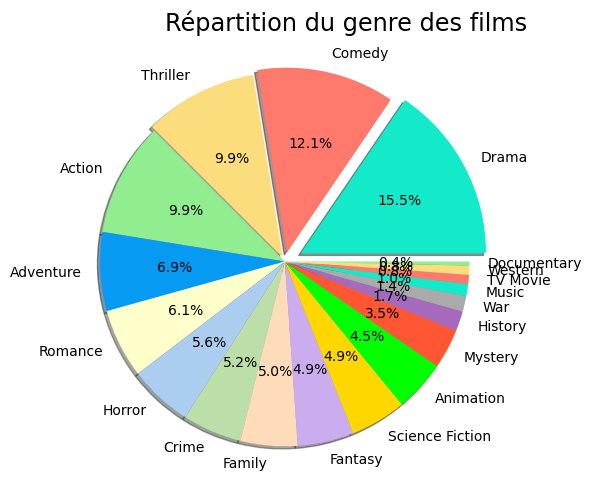

In [26]:
genre_count_dict = {}

# Parcourir les listes de genres pour chaque film et compter le nombre de films pour chaque genre
for genres_list in movies_data['genres']:
    for genre in genres_list:
        if genre in genre_count_dict:
            genre_count_dict[genre] += 1
        else:
            genre_count_dict[genre] = 1

Autres=["History","Music","War", "TV Movie","Western","Documentary"]

# Convertir le dictionnaire en DataFrame pour obtenir le décompte du nombre de films par genre
genre_counts = pd.DataFrame(list(genre_count_dict.items()), columns=['Genre', 'Count'])
genre_counts = genre_counts.sort_values(by='Count', ascending=False)

import matplotlib.pyplot as plt

# Utiliser les décomptes réels à partir de 'genre_counts'
Liste = genre_counts['Count'].tolist()  # Utiliser les décomptes pour les 16 premiers genres
Labels = genre_counts['Genre'].tolist() # Utiliser les noms des 16 premiers genres
myexplode = [0.2,0.1,0.05]+[0] * 16  # Explosion pour la première tranche, pas d'explosion pour les autres
colors = ['#13EAC9', '#FF796C', '#FBDD7E', '#90EE90', '#069AF3', '#FFFFCB', '#ABCDEF', '#BCDFAA', '#FEDCBA', '#CBADEF', '#FFD700', '#00FF00', '#FF5733', '#A569BD', '#AAAAAA']

# Création du pie chart avec les données de décompte réelles
plt.figure(figsize=(5, 3))
plt.pie(Liste, labels=Labels, explode=myexplode, colors=colors, autopct='%1.1f%%', startangle=0, shadow=True, radius=2)
plt.text(-1.3, 2.5, "Répartition du genre des films", fontsize='xx-large')
plt.show()




Plus de 15% de la production cinématographique est attribuée aux films dramatiques. 

Environ la moitié de cette production est partagée entre les genres du drame, de la comédie, du thriller et des films d'action

# Pays Producteurs

In [54]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
# Charger le jeu de données des pays du monde
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
print(world)
# Compter le nombre de films produits par pays
country_counts = movies_data['production_countries'].value_counts()

# Ajouter une colonne avec le nombre de films par pays
world['num_films'] = world['name'].map(country_counts)

# Remplacer les valeurs NaN par 0
world['num_films'].fillna(0, inplace=True)

# Normaliser les données pour définir la taille des cercles
world['circle_size'] = world['num_films'] / world['num_films'].max()

# Créer la carte
fig, ax = plt.subplots(figsize=(15, 10))

# Utiliser le fond de carte Stamen Terrain avec contextily
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain)

# Ajouter des cercles en fonction du nombre de films produits par pays
for idx, row in world.iterrows():
    if row['circle_size'] > 0:
        ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y,
                   s=row['circle_size'] * 500, c='navy', edgecolors='black')
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['name'], fontsize=8,
                 ha='center', va='center')

# Titre de la carte
plt.title('Nombre de films produits par pays')

# Ajouter une échelle pour les cercles
plt.scatter([], [], s=100, c='navy', edgecolors='black', label='100 films')
plt.scatter([], [], s=250, c='navy', edgecolors='black', label='250 films')
plt.scatter([], [], s=500, c='navy', edgecolors='black', label='500 films')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper right')  # Position de la légende

plt.axis('off')
plt.show()


         pop_est      continent                      name iso_a3  gdp_md_est  \
0       889953.0        Oceania                      Fiji    FJI        5496   
1     58005463.0         Africa                  Tanzania    TZA       63177   
2       603253.0         Africa                 W. Sahara    ESH         907   
3     37589262.0  North America                    Canada    CAN     1736425   
4    328239523.0  North America  United States of America    USA    21433226   
..           ...            ...                       ...    ...         ...   
172    6944975.0         Europe                    Serbia    SRB       51475   
173     622137.0         Europe                Montenegro    MNE        5542   
174    1794248.0         Europe                    Kosovo    -99        7926   
175    1394973.0  North America       Trinidad and Tobago    TTO       24269   
176   11062113.0         Africa                  S. Sudan    SSD       11998   

                                       

/Users/y.boukhateb/anaconda3/lib/python3.11/site-packages/contextily/tile.py:614: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


ValueError: Image size of 219808x85360 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1500x1000 with 1 Axes>

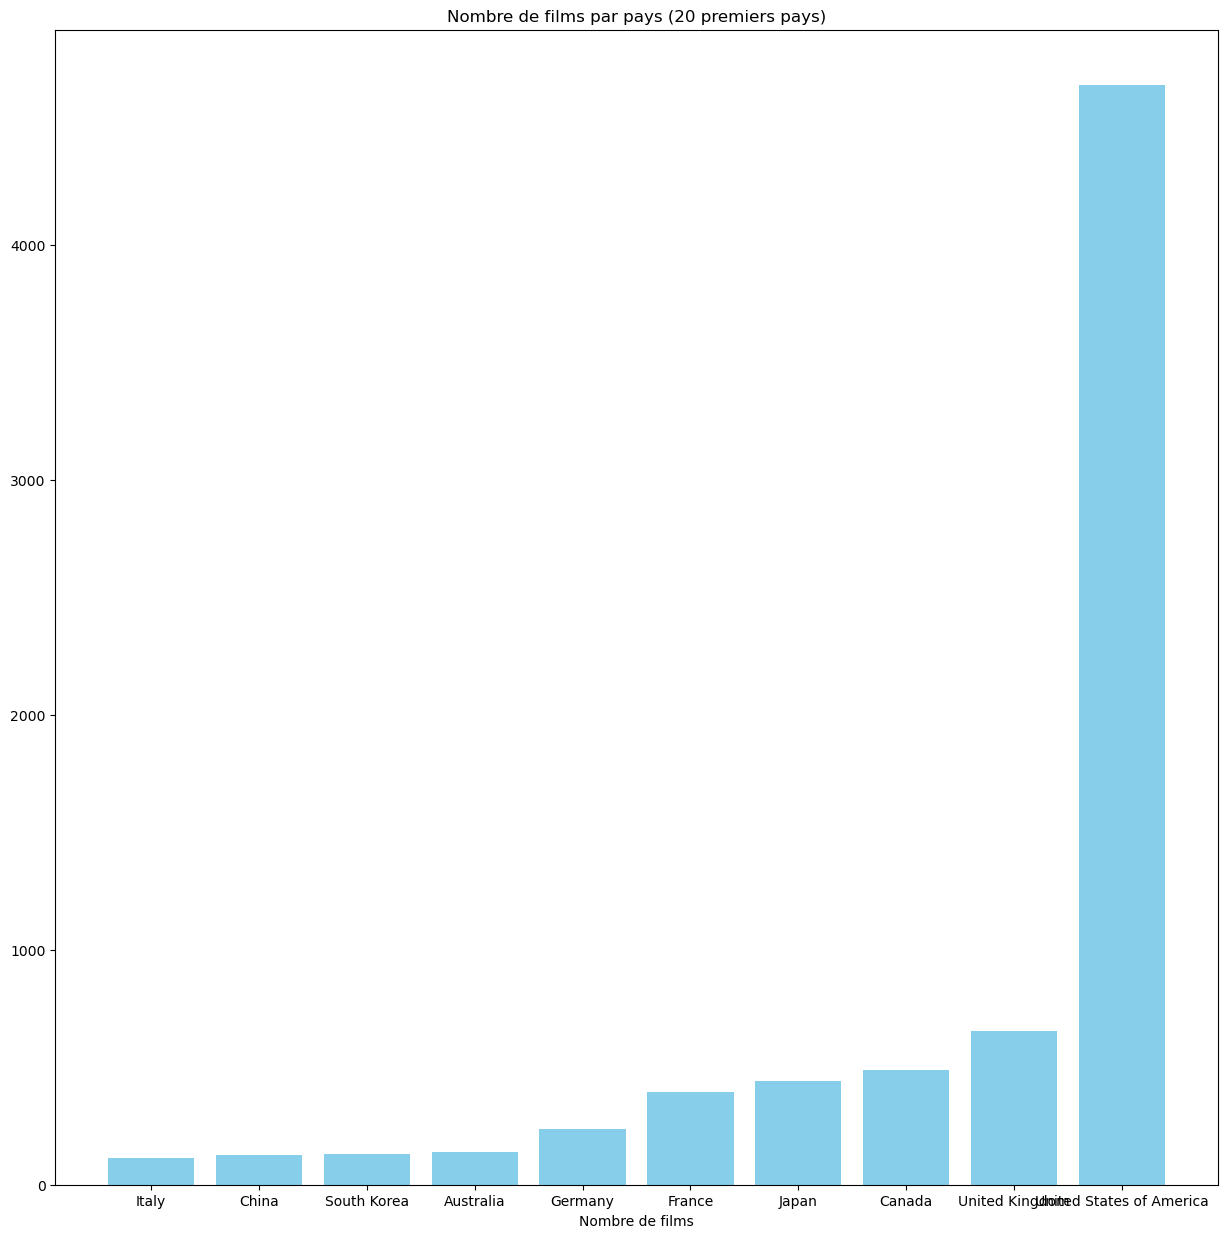

In [73]:
# Compter le nombre de films par pays
films_par_pays = movies_data['production_countries'].value_counts().reset_index()
films_par_pays.columns = ['Pays', 'Nombre de films']
films_par_pays = films_par_pays.sort_values('Nombre de films', ascending=True)

# Garder uniquement les 10 premiers pays pour l'affichage
top_countries_to_keep = 10
plt.figure(figsize=(15, 15))
plt.bar(films_par_pays['Pays'].iloc[-top_countries_to_keep:], films_par_pays['Nombre de films'].iloc[-top_countries_to_keep:], color='skyblue')
plt.xlabel('Nombre de films')
plt.title('Nombre de films par pays (10 premiers pays)')
plt.show()


les USA est une monopole dans la production cinématographique, sa production dépasse la somme des productions des autres 9 pays les plus producteurs ensemble  

In [85]:
# Créer une copie du DataFrame pour éviter les modifications accidentelles
movies_genre = movies_data.copy()

# Appliquer explode pour étendre les listes de genres en lignes individuelles
movies_genre = movies_genre.explode('genres')

# Obtenir l'indice du film le mieux noté par genre
best_rated_indices = movies_genre.groupby('genres')['vote_average'].idxmax()

# Obtenir les détails des films les mieux notés par genre
best_rated_details = movies_genre.loc[best_rated_indices, ['genres', 'title', 'vote_average', 'vote_count',"popularity"]]

# Afficher les détails des films les mieux notés par genre
best_rated_details

,genres,title,vote_average,vote_count,popularity
19,Action,Aquaman and the Lost Kingdom,9.000,11,522.991
19,Adventure,Aquaman and the Lost Kingdom,9.000,11,522.991
19,Fantasy,Aquaman and the Lost Kingdom,9.000,11,522.991
19,Action,Aquaman and the Lost Kingdom,9.000,11,522.991
19,Adventure,Aquaman and the Lost Kingdom,9.000,11,522.991
19,Fantasy,Aquaman and the Lost Kingdom,9.000,11,522.991
2113,Animation,IDOLiSH7 Movie: LIVE 4bit - BEYOND THE PERiOD,9.500,2,36.714
2113,Music,IDOLiSH7 Movie: LIVE 4bit - BEYOND THE PERiOD,9.500,2,36.714
1118,Comedy,Anyone But You,9.500,3,78.966
1118,Romance,Anyone But You,9.500,3,78.966


In [93]:
# Créer une copie du DataFrame pour éviter les modifications accidentelles
movies_countries = movies_data.copy()

# Appliquer explode pour étendre les listes de pays de production en lignes individuelles
movies_countries = movies_countries.explode('production_countries')

# Trier les données par note (vote_average) en ordre décroissant et par nombre de votes (vote_count) en ordre décroissant
movies_countries = movies_countries.sort_values(by=['production_countries', 'vote_average', 'vote_count'], ascending=[True, False, True])

# Garder uniquement le premier film pour chaque pays avec la note la plus élevée et, en cas d'égalité de notes, le film avec le plus de votes
best_rated_details_countries = movies_countries.drop_duplicates(subset='production_countries', keep='first')

# Sélectionner les colonnes requises pour l'affichage des détails
best_rated_details_countries = best_rated_details_countries[['production_countries', 'title', 'vote_average', 'vote_count', 'popularity']]

# Afficher les détails des films les mieux notés par pays de production
best_rated_details_countries


,production_countries,title,vote_average,vote_count,popularity
4386,Argentina,The Secret in Their Eyes,7.988,2338,42.333
4337,Aruba,Knock Off,5.300,324,25.805
7380,Australia,Taylor Swift: The 1989 World Tour - Live,8.545,132,23.499
4404,Austria,Before Sunrise,7.968,3801,29.927
5089,Bahamas,Bill & Ted Face the Music,5.913,825,39.336
...,...,...,...,...,...
511,Ukraine,Sniper: The White Raven,7.638,552,74.286
185,United Arab Emirates,Rally Road Racers,7.400,19,131.947
7425,United Kingdom,David Attenborough: A Life on Our Planet,8.523,308,32.470
1118,United States of America,Anyone But You,9.500,3,78.966


In [ ]:


# Grouper les données par pays de production et calculer la note moyenne
average_ratings_by_country = movies_data.groupby('production_countries')['vote_average'].mean().reset_index()

# Renommer la colonne 'vote_average' pour plus de clarté
average_ratings_by_country = average_ratings_by_country.rename(columns={'vote_average': 'average_rating'})

# Afficher le DataFrame résultant avec la note moyenne par pays
average_ratings_by_country=pd.DataFrame(average_ratings_by_country)
average_ratings_by_country.head()

,production_countries,average_rating
0,Argentina,6.199412
1,Aruba,5.200000
2,Australia,6.437106
3,Austria,6.958143
4,Bahamas,5.913000


In [31]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world['Country'] = world['name']
world = world[['geometry', 'Country']]

In [32]:
world_movies = pd.merge(world, average_ratings_by_country, how='left', left_on='Country', right_on='production_countries')
world_movies.head()

,geometry,Country,production_countries,average_rating
0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",Fiji,NaN,NaN
1,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,NaN,NaN
2,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",W. Sahara,NaN,NaN
3,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,Canada,6.226222
4,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States of America,United States of America,6.491104


<Axes: >

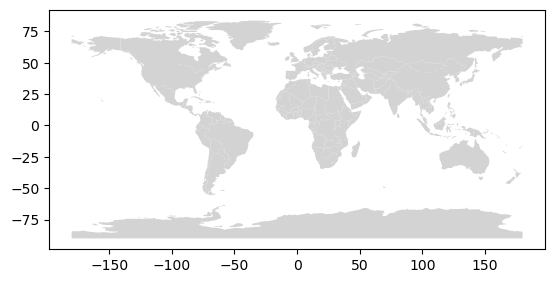

In [33]:
world_movies.plot(color='lightgrey')

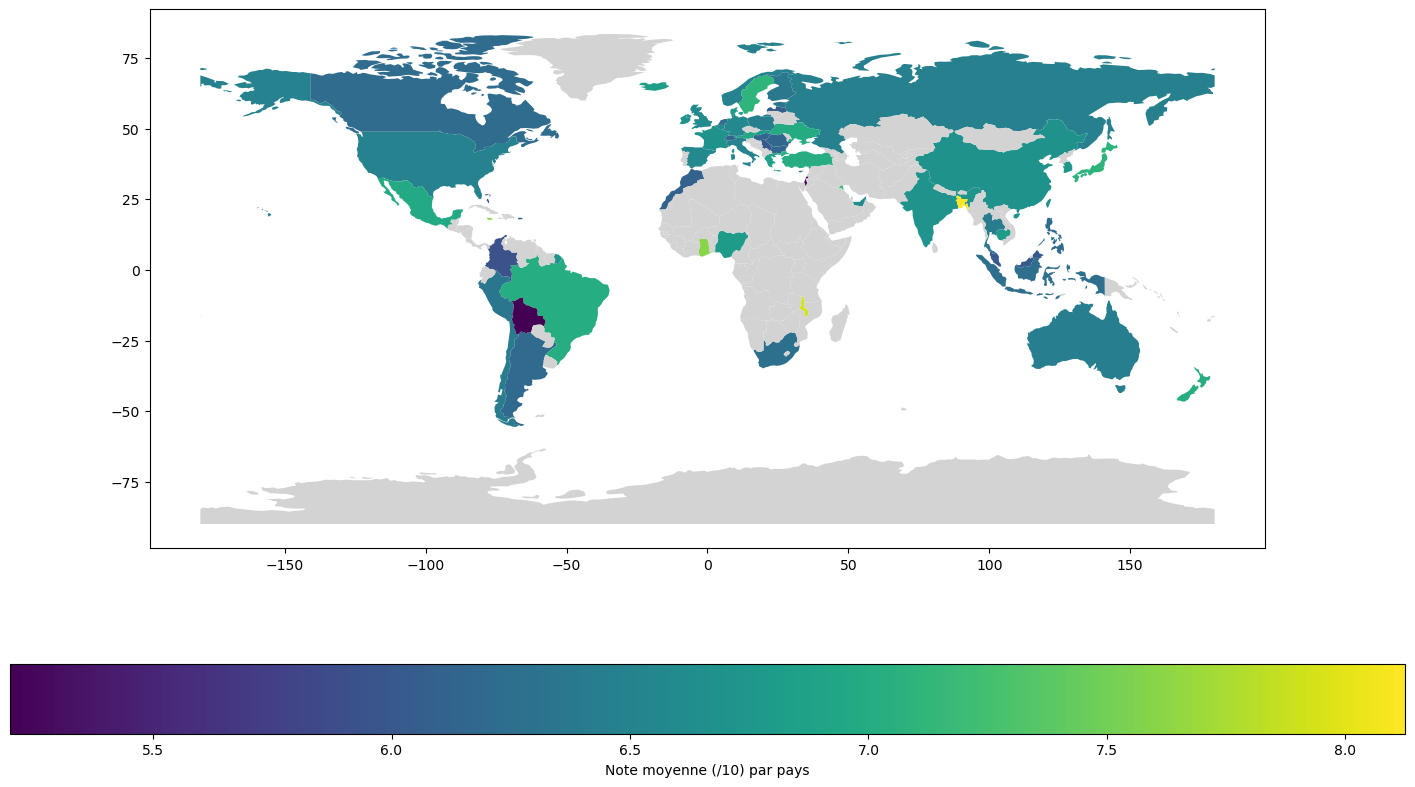

In [35]:
world_movies.plot(
    column="average_rating",
    legend=True,
    legend_kwds={'label': "Note moyenne (/10) par pays",
                        'orientation': "horizontal"},
    figsize=(18, 10),
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    },
);

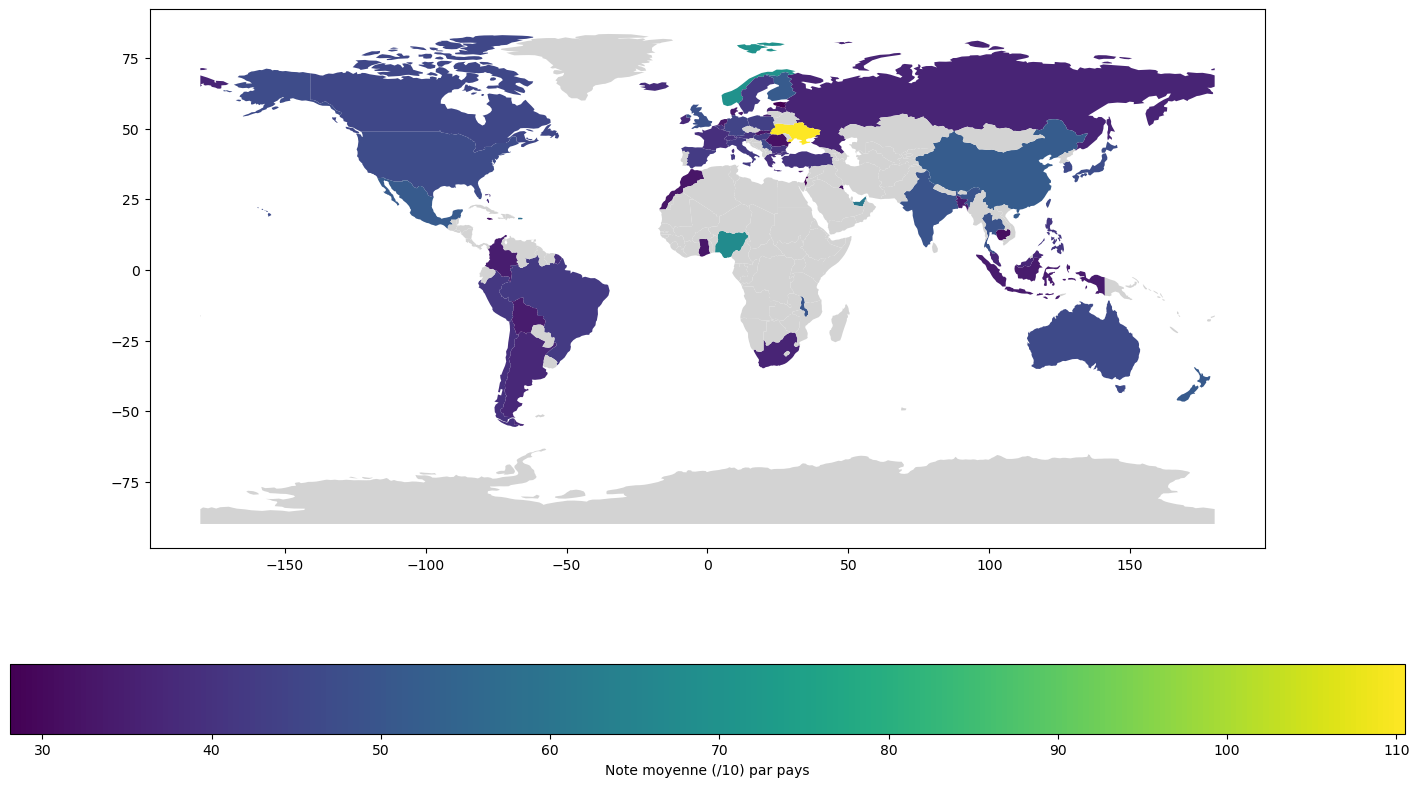

In [45]:
# Supposons que 'movies_data' est le nom de votre DataFrame

# Grouper les données par pays de production et calculer la popularité moyenne
popularity_by_country = movies_data.groupby('production_countries')['popularity'].mean().reset_index()

# Renommer la colonne pour plus de clarté
popularity_by_country = popularity_by_country.rename(columns={'popularity': 'average_popularity'})

# Afficher le DataFrame résultant avec la popularité moyenne par pays
popularity_by_country=pd.DataFrame(popularity_by_country)
world2 = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world2['Country'] = world2['name']
world2 = world2[['geometry', 'Country']]
world2_movies = pd.merge(world2, popularity_by_country, how='left', left_on='Country', right_on='production_countries')
world2_movies.plot(
    column="average_popularity",
    legend=True,
    legend_kwds={'label': "Note moyenne (/10) par pays",
                        'orientation': "horizontal"},
    figsize=(18, 10),
    missing_kwds={
        "color": "lightgrey",
        "label": "Missing values",
    },
);

### IV. Modélisation

#### IV.1 Préprocessing

On récupère les colonnes pertinentes pour comparer les films entre eux :

* `id`

* `title`
* `overview`
* `genres`
* `keywords`
* `cast`
* `crew`


In [167]:
movies_reco=movies_data[["id","title","overview","genres","keywords","cast","crew"]]
movies_reco.head()

,id,title,overview,genres,keywords,cast,crew
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,"[Crime, Drama, History]","[husband wife relationship, based on novel or ...","[Leonardo DiCaprio, Lily Gladstone, Robert De ...",[Martin Scorsese]
1,897087,Freelance,An ex-special forces operative takes a job to ...,"[Action, Comedy]","[coup d'etat, dictatorship, political assassin...","[John Cena, Alison Brie, Juan Pablo Raba]",[Pierre Morel]
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...,"[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[Timothée Chalamet, Calah Lane, Keegan-Michael...",[Paul King]
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...","[Animation, Family, Music, Fantasy, Comedy]","[pop star, brother, musical, sequel, based on ...","[Anna Kendrick, Justin Timberlake, Camila Cabe...",[Walt Dohrn]
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...,"[Animation, Comedy, Family]","[classroom, musical, bucket list]","[Adam Sandler, Bill Burr, Cecily Strong]",[Robert Smigel]


On enlève les espaces inutiles dans les colonnes ` cast`, `crew`, `genres` et `keywords` pour éviter des similarités entre des films où juste le prénom d'un acteur ou du réalisateur sont en commun.

In [168]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1
movies_reco['cast'] = movies_reco['cast'].apply(collapse)
movies_reco['crew'] = movies_reco['crew'].apply(collapse)
movies_reco['genres'] = movies_reco['genres'].apply(collapse)
movies_reco['keywords'] = movies_reco['keywords'].apply(collapse)
movies_reco.head()

/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_59635/813522039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['cast'] = movies_reco['cast'].apply(collapse)
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_59635/813522039.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['crew'] = movies_reco['crew'].apply(collapse)
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_59635/813522039.py:8: SettingWithCopyWarning: 
A value is trying to be set on a cop

,id,title,overview,genres,keywords,cast,crew
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...,"[Crime, Drama, History]","[husbandwiferelationship, basedonnovelorbook, ...","[LeonardoDiCaprio, LilyGladstone, RobertDeNiro]",[MartinScorsese]
1,897087,Freelance,An ex-special forces operative takes a job to ...,"[Action, Comedy]","[coupd'etat, dictatorship, politicalassassinat...","[JohnCena, AlisonBrie, JuanPabloRaba]",[PierreMorel]
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...,"[Comedy, Family, Fantasy]","[chocolate, musical, prequel]","[TimothéeChalamet, CalahLane, Keegan-MichaelKey]",[PaulKing]
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for...","[Animation, Family, Music, Fantasy, Comedy]","[popstar, brother, musical, sequel, basedontoy...","[AnnaKendrick, JustinTimberlake, CamilaCabello]",[WaltDohrn]
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...,"[Animation, Comedy, Family]","[classroom, musical, bucketlist]","[AdamSandler, BillBurr, CecilyStrong]",[RobertSmigel]


On crée une colonne `label` contenant les informations des colonnes/features conservées.

In [169]:
movies_reco['overview'] = movies_reco['overview'].apply(lambda x:x.split())
movies_reco["title_bis"]=movies_reco["title"].apply(lambda x:x.split())
movies_reco['label'] = movies_reco['overview']+movies_reco['title_bis']+movies_reco['genres'] + movies_reco['keywords'] + movies_reco['cast'] + movies_reco['crew']
data_model=movies_reco.drop(columns=['overview','genres','keywords','cast','crew',"title_bis"])
data_model['label'] = data_model['label'].apply(lambda x: " ".join(x))
data_model.head()

/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_59635/2911585339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco['overview'] = movies_reco['overview'].apply(lambda x:x.split())
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_59635/2911585339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reco["title_bis"]=movies_reco["title"].apply(lambda x:x.split())
/var/folders/8w/8q5hgk2d2wnfsvdq9brjz71h0000gn/T/ipykernel_59635/2911585339.py:3: SettingWithCopyWarning: 
A

,id,title,label
0,466420,Killers of the Flower Moon,When oil is discovered in 1920s Oklahoma under...
1,897087,Freelance,An ex-special forces operative takes a job to ...
2,787699,Wonka,Willy Wonka – chock-full of ideas and determin...
3,901362,Trolls Band Together,"When Branch's brother, Floyd, is kidnapped for..."
4,1075794,Leo,Jaded 74-year-old lizard Leo has been stuck in...


**Traitement de texte :** On applique la fonction `stem`,utilisant la bibliothèque NLTK (Natural Language Toolkit) pour le prétraitement des données textuelles, pour enlever les suffixes inutiles.
 
 Voici une explication simple étape par étape : 

 * Le code commence par l'importation du PorterStemmer, qui est un algorithme de stemming (racinisation) souvent utilisé pour réduire les mots à leur racine. 
 
 * La fonction stem(text) prend en entrée un texte et le traite pour réduire chaque mot à sa racine. Le stemming est un processus qui consiste à réduire les mots à leur forme de base ou racine, ce qui aide à regrouper différentes variantes d'un mot ensemble.

 * On met tout le texte en minuscule avec la méthode .lower()

In [170]:
ps =PorterStemmer()
def stem(text): # stem("dancing")=>"danc"
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)
data_model["label"]=data_model["label"].apply(stem)
data_model["label"]=data_model["label"].apply(lambda x : x.lower())
data_model.head()

,id,title,label
0,466420,Killers of the Flower Moon,when oil is discov in 1920 oklahoma under osag...
1,897087,Freelance,an ex-speci forc oper take a job to provid sec...
2,787699,Wonka,willi wonka – chock-ful of idea and determin t...
3,901362,Trolls Band Together,"when branch' brother, floyd, is kidnap for hi ..."
4,1075794,Leo,jade 74-year-old lizard leo ha been stuck in t...


Une instance de CountVectorizer est créée avec les paramètres suivants :
* **max_features=5000:** Cela spécifie le nombre maximum de fonctionnalités (mots dans ce contexte) à extraire des textes. Seuls les 5000 mots les plus fréquents seront pris en compte.

* **stop_words='english':** Cette option indique à CountVectorizer d'utiliser les mots vides (stop words) en anglais. Les mots vides sont des mots courants qui sont souvent supprimés car ils ne portent pas beaucoup d'informations (par exemple, "the", "is", "and", etc.).

* **La méthode fit_transform()** est utilisée pour transformer les données textuelles de la colonne "label" du DataFrame data_model en une représentation numérique. Cela signifie que chaque texte est converti en un vecteur de nombres représentant la fréquence des mots dans ce texte.

On reviendra plus tard sur ce choix de vectorisation.

In [171]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
vector = cv.fit_transform(data_model['label']).toarray()

#### IV.2 Le modèle de cosine similarity

La similarité cosinus (cosine similarity) est une mesure de similarité entre deux vecteurs dans l'espace vectoriel. En utilisant la bibliothèque sklearn, la fonction cosine_similarity est utilisée pour calculer la similarité cosinus entre les vecteurs. 

**Voici la formule mathématique de la similarité cosinus :** La formule de la similarité cosinus pour deux vecteurs $A$ et $B$ est donnée par :
<center>

$\text{CS}(\mathbf{A}, \mathbf{B}) = \frac{<\mathbf{A},\mathbf{B}>}{\|\mathbf{A}\| \cdot \|\mathbf{B}\|}$

</center>

avec $<,>$ le produit scalaire usuelle dans $R^{d}$ et $\|\mathbf{X}\|$ le norme de $X$. C'est la généralisation du cosinus en dimension $d\geq2$.
<center>

![Texte alternatif](./cosine_similarity_figure.png )
</center>

<center>

**Fig :** Principe du cosine simalarity
</center>


On crée donc la matrice de similarity ($S$) :

- on a donc $S_{i,j}=CS(M_{i},M_{j})$ avec $M_{k}$ le label vectorisé du $k$-ème films. A remarquer que la diagonale ne contient que des 1.

In [191]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vector)
similarity

array([[1.        , 0.        , 0.        , ..., 0.01690309, 0.06172134,
        0.        ],
       [0.        , 1.        , 0.03774257, ..., 0.09200874, 0.        ,
        0.03513642],
       [0.        , 0.03774257, 1.        , ..., 0.02344036, 0.0855921 ,
        0.10741723],
       ...,
       [0.01690309, 0.09200874, 0.02344036, ..., 1.        , 0.02608203,
        0.04364358],
       [0.06172134, 0.        , 0.0855921 , ..., 0.02608203, 1.        ,
        0.        ],
       [0.        , 0.03513642, 0.10741723, ..., 0.04364358, 0.        ,
        1.        ]])

On remarque qu'il y a aucune valeur négative.

On fait un changement d'échelle sur la matrice de similarité. C'est juste pour lisser les scores de recommandations dans l'application.

In [192]:
# Appliquer la fonction ln(2+x) sur chaque ligne de la matrice
similarity = np.log(1+similarity)
for i in range(len(similarity)):
    # Calculer le maximum de la ligne
    max_ligne = np.max(similarity[i])
    
    # Diviser chaque élément de la ligne par le maximum (sauf pour la diagonale)
    for j in range(len(similarity)):
        similarity[i][j] = similarity[i][j] / max_ligne

similarity

array([[1.        , 0.        , 0.        , ..., 0.02418219, 0.08640517,
        0.        ],
       [0.        , 1.        , 0.0534486 , ..., 0.1269844 , 0.        ,
        0.04982091],
       [0.        , 0.0534486 , 1.        , ..., 0.03342704, 0.11848213,
        0.14719888],
       ...,
       [0.02418219, 0.1269844 , 0.03342704, ..., 1.        , 0.03714607,
        0.06162909],
       [0.08640517, 0.        , 0.11848213, ..., 0.03714607, 1.        ,
        0.        ],
       [0.        , 0.04982091, 0.14719888, ..., 0.06162909, 0.        ,
        1.        ]])

Enfin, on définit la fonction `recommend` qui prend en argument le nom du film que l'on souhaite et le nombre de films que l'on veut en sortie :
* **On récupère l'index du film dans le DataFrame :** La fonction prend le nom d'un film en entrée et trouve son indice dans le DataFrame data_model.

* **On a accès aux similarités :** on a la similarité entre ce film et tous les autres films à l'aide de la matrice de similarité préalablement générée (similarity). Ces similarités sont triées par ordre décroissant afin de trouver les films les plus similaires.
* **Afficher les films recommandés :** on affiche les titres des films recommandés en fonction de leur similarité avec le film donné.

In [174]:
def recommend(movie,m):
    index = data_model[data_model['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:m+1]:
        print(data_model.iloc[i[0]].title)

In [178]:
recommend("Freelance",5)

An Interview with God
Bushwick
The Interview
Bad Teacher
Cats & Dogs: The Revenge of Kitty Galore


Ainsi, se conclut la partie programmation du modèle. Je vous invite à aller voir le fichier `movie_recommender_app.py` et executer le code pour pouvoir lancer l'application `Dash` en local. On récupère la matrice de similarité ci-dessous ainsi, que la base `movies_data` via la librairie `pickle`.

In [193]:
pickle.dump(movies_data.to_dict(),open("movies_details.pkl","wb"))
pickle.dump(similarity,open("similarity.pkl","wb"))